In [1]:
import numpy as np
import pandas as pd

import re
import spacy
import string
from textblob import TextBlob
from textstat import textstat
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

from scipy.sparse import vstack
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import jaccard_score, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

import tensorflow_decision_forests as tfdf
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns


nlp = spacy.load('en_core_web_sm')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
pd.set_option('display.max_columns', None);

2024-02-15 09:15:12.700935: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 09:15:12.700994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 09:15:12.744249: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 09:15:12.835441: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-15 09:15:13.973081: W tensorflow/compiler/tf2

In [2]:
df_train_prompt = pd.read_csv('commonlit-evaluate-student-summaries/prompts_train.csv')
df_train_summaries = pd.read_csv('commonlit-evaluate-student-summaries/summaries_train.csv')
# df_train = df_train_summaries.merge(df_train_prompt, on='prompt_id')

## **Feature engineering**

In [11]:
def relative_length(df: pd.DataFrame, prompt_id: str, length: int) -> float:
    rel_length = length / len(df[df.prompt_id == prompt_id]['prompt'].values[0])
    return rel_length


# Count the stop words in the text
def count_stopwords(text: str) -> int:
    stopword_list = set(stopwords.words('english'))
    words = text.split()
    stopwords_count = sum(1 for word in words if word.lower() in stopword_list)
    return stopwords_count

# Count the punctuations in the text
# punctuation_set -> !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
def count_punctuation(text: str) -> int:
    punctuation_set = set(string.punctuation)
    punctuation_count = sum(1 for char in text if char in punctuation_set)
    return punctuation_count

# Count the digits in the text
def count_numbers(text: str) -> int:
    numbers = re.findall(r'\d+', text)
    numbers_count = len(numbers)
    return numbers_count

dict_tags = {'verb': ['VB', 'VBZ', 'VBP', 'VBD', 'VBN', 'VBG'],
             'noun': ['NN', 'NNS', 'NNP', 'NNPS'],
             'adj': ['JJ', 'JJR', 'JJS']}

# Clean and lemmatize the text
def lemmatize_text(text: str) -> list:
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = []
    for word in filtered_text:
        pos_tag = nltk.pos_tag([word])[0][1]
        if len(word) > 2:
            if pos_tag in dict_tags['verb']:
                lemmatized_text.append(lemmatizer.lemmatize(word, pos='v'))
            elif pos_tag in dict_tags['noun']:
                lemmatized_text.append(lemmatizer.lemmatize(word, pos='n'))
            elif pos_tag in dict_tags['adj']:
                lemmatized_text.append(lemmatizer.lemmatize(word, pos='a'))
            else:
                lemmatized_text.append(lemmatizer.lemmatize(word))
    return lemmatized_text

# This function applies lemmatize_text on text features
def lemmatize(dataframe : pd.DataFrame, features: str | list) -> pd.DataFrame:
    if isinstance(features, str):
        features = [features]
    for feature in features:
        dataframe[f'{feature}_lemmatized'] = dataframe[feature].apply(lemmatize_text)
    return dataframe

# Count unique words in the lemmatized text
def count_unique_words(words: list) -> int:
    unique_words_count = len(set(words))
    return unique_words_count


# Trains a vectorizer on a text
def vectorizer(df: pd.DataFrame, vectorizer=CountVectorizer(), n: int = 50) -> dict:
    vectorizer_dict = {}
    for _, row in df.iterrows():
        vectorizer_dict[row['prompt_id']] = {}
        for text in ['prompt', 'prompt_question']:
            lemmatized_text = ' '.join(row[f'{text}_lemmatized'])
            vectorizer.fit([lemmatized_text])
            word_counts = pd.DataFrame(vectorizer.transform([lemmatized_text]).toarray(), columns=vectorizer.get_feature_names_out())
            top_n_words = word_counts.sum().nlargest(n).index
            top_n_vectorizer = CountVectorizer(vocabulary=top_n_words)
            vectorizer_dict[row['prompt_id']][text] = top_n_vectorizer.fit([lemmatized_text])
    return vectorizer_dict


# Transform a list in a vector
def vectorize(lst: list, vectorizer: CountVectorizer) -> np.ndarray:
    sparse_matrix = vectorizer.transform([' '.join(lst)])
    vector = sparse_matrix.toarray()
    return vector

# Calculates Jaccard Similarity between two vectors
def jaccard_similarity(vec1: np.ndarray, vec2: np.ndarray) -> float:
    binary_vec1 = [1 if i else 0 for i in vec1[0]]
    binary_vec2 = [1 if i else 0 for i in vec2[0]]
    return jaccard_score(binary_vec1, binary_vec2)


# Extract NER
def ner(text: str) -> pd.DataFrame:
    vector = [(ent.text, ent.label_) for ent in nlp(text).ents]
    return vector

def jaccard_similarity_ner(list1: list[tuple[str]], list2: list[tuple[str]]) -> float:
    set1 = set(list1)
    set2 = set(list2)
    union_set = set1.union(set2)
    binary_vec1 = [1 if i in set1 else 0 for i in union_set]
    binary_vec2 = [1 if i in set2 else 0 for i in union_set]
    return jaccard_score(binary_vec1, binary_vec2)


def readability(text: str) -> pd.Series:
    flesch_reading_ease = textstat.flesch_reading_ease(text)
    gunning_fog = textstat.gunning_fog(text)
    ari = textstat.automated_readability_index(text)
    return pd.Series([flesch_reading_ease, gunning_fog, ari])


def cosine_similarity_sentiment(a: tuple[float], b: tuple[float]) -> float:
    if np.linalg.norm(a)*np.linalg.norm(b) == 0:
        return 0
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

def sentiment(df: pd.DataFrame, text: str, prompt_id: str) -> float:
    text_blob = TextBlob(text)
    prompt_blob = df[df.prompt_id == prompt_id]['blob'].values[0]
    similarity = cosine_similarity_sentiment(prompt_blob.sentiment, text_blob.sentiment)
    return similarity


In [12]:
df_train_prompt['prompt'] = df_train_prompt['prompt_title'] + '\n' + df_train_prompt['prompt_text']
df_train_prompt = lemmatize(df_train_prompt, ['prompt_question', 'prompt'])

vectorizer_dict = vectorizer(df_train_prompt)
df_train_prompt['vector_text'] = df_train_prompt.apply(lambda row: vectorize(row['prompt_lemmatized'], vectorizer_dict[row.prompt_id]['prompt']), axis=1)
df_train_prompt['vector_question'] = df_train_prompt.apply(lambda row: vectorize(row['prompt_question_lemmatized'], vectorizer_dict[row.prompt_id]['prompt_question']), axis=1)

df_train_prompt['ner_text'] = df_train_prompt.apply(lambda row: ner(row['prompt']), axis=1)
# df_train_prompt['ner_question'] = df_train_prompt.apply(lambda row: ner(row['prompt_question']), axis=1)

df_train_prompt['blob'] = df_train_prompt['prompt'].apply(TextBlob)

In [13]:
# This function applies all the above preprocessing functions on a text feature
def feature_engineer(dataframe: pd.DataFrame, feature: str = 'text') -> pd.DataFrame:
    print('Calculating word count...                 ', end='')
    dataframe['word_cnt'] = dataframe[feature].apply(lambda x: len(x.split(' ')))
    print('   | Done')
    print('Calculating length...                     ', end='')
    dataframe['length'] = dataframe[feature].apply(len)
    print('   | Done')
    print('Calculating relative length...            ', end='')
    dataframe['relative_length'] = dataframe.apply(lambda row: relative_length(df_train_prompt, row.prompt_id, row.length), axis=1)
    print('   | Done')
    print('Calculating stopword relative count...    ', end='')
    dataframe['stopword_cnt'] = dataframe[feature].apply(count_stopwords) / dataframe['word_cnt']
    print('   | Done')
    print('Calculating punctuation relative count... ', end='')
    dataframe['punct_cnt'] = dataframe[feature].apply(count_punctuation) / dataframe['word_cnt']
    print('   | Done')
    print('Calculating number relative count...      ', end='')
    dataframe['number_cnt'] = dataframe[feature].apply(count_numbers) / dataframe['word_cnt']
    print('   | Done')
    print('Lemmatizing...                            ', end='')
    dataframe = lemmatize(dataframe, feature)
    print('   | Done')
    print('Calculating unique words count...         ', end='')
    dataframe['unique_words_cnt'] = dataframe[f'{feature}_lemmatized'].apply(count_unique_words)
    dataframe['relative_unique_words_cnt'] = dataframe['unique_words_cnt'] / len(dataframe[f'{feature}_lemmatized'])
    dataframe['unique_words_ratio'] = dataframe['unique_words_cnt'] / dataframe['word_cnt']
    print('   | Done')
    print('Vectorizing...                            ', end='')
    dataframe[f'{feature}_vector_text'] = dataframe.apply(lambda row: vectorize(row[f'{feature}_lemmatized'], vectorizer_dict[row.prompt_id]['prompt']), axis=1)
    dataframe[f'{feature}_vector_question'] = dataframe.apply(lambda row: vectorize(row[f'{feature}_lemmatized'], vectorizer_dict[row.prompt_id]['prompt_question']), axis=1)
    print('   | Done')
    print('Calculating Jaccard Similarity...         ', end='')
    dataframe['jaccard_similarity_prompt'] = dataframe.apply(lambda row: jaccard_similarity(row[f'{feature}_vector_text'], df_train_prompt.at[df_train_prompt[df_train_prompt.prompt_id == row.prompt_id].index[0], 'vector_text']), axis=1)
    dataframe['jaccard_similarity_question'] = dataframe.apply(lambda row: jaccard_similarity(row[f'{feature}_vector_question'], df_train_prompt.at[df_train_prompt[df_train_prompt.prompt_id == row.prompt_id].index[0], 'vector_question']), axis=1)
    print('   | Done')
    print('Calculating NER...                        ', end='')
    dataframe[f'{feature}_ner'] = dataframe[feature].apply(ner)
    print('   | Done')
    print('Calculating NER Jaccard Similarity...     ', end='')
    dataframe['ner_jaccard_similarity_prompt'] = dataframe.apply(lambda row: jaccard_similarity_ner(row[f'{feature}_ner'], df_train_prompt.at[df_train_prompt[df_train_prompt.prompt_id == row.prompt_id].index[0], 'ner_text']), axis=1)
    # dataframe['ner_jaccard_similarity_question' = dataframe.apply(lambda row: jaccard_similarity_ner(row[f'{feature}_ner'], df_train_prompt.at[df_train_prompt[df_train_prompt.prompt_id == row.prompt_id].index[0], 'ner_question']), axis=1)
    print('   | Done')
    print('Evaluating readability...                 ', end='')
    dataframe[['flesch_reading_ease', 'gunning_fog', 'ari']] = dataframe[feature].apply(readability)
    print('   | Done')
    print('Evaluating sentiment...                   ', end='')
    dataframe['sentiment_similarity'] = dataframe.apply(lambda row: sentiment(df_train_prompt, row[feature], row['prompt_id']), axis=1)
    print('   | Done')
    return dataframe

In [14]:
df_train_summaries = feature_engineer(df_train_summaries)
df_train_summaries.head()

Calculating word count...                    | Done
Calculating length...                        | Done
Calculating relative length...               | Done
Calculating stopword relative count...       | Done
Calculating punctuation relative count...    | Done
Calculating number relative count...         | Done
Lemmatizing...                               | Done
Calculating unique words count...            | Done
Vectorizing...                               | Done
Calculating Jaccard Similarity...            | Done
Calculating NER...                           | Done
Calculating NER Jaccard Similarity...        | Done
Evaluating readability...                    | Done
Evaluating sentiment...                      | Done


,student_id,prompt_id,text,content,wording,word_cnt,length,relative_length,stopword_cnt,punct_cnt,number_cnt,text_lemmatized,unique_words_cnt,relative_unique_words_cnt,unique_words_ratio,text_vector_text,text_vector_question,jaccard_similarity_prompt,jaccard_similarity_question,text_ner,ner_jaccard_similarity_prompt,flesch_reading_ease,gunning_fog,ari,sentiment_similarity
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,61,346,346.0,0.409836,0.049180,0.000000,"[third, wave, experimentto, see, people, react...",30,0.004187,0.491803,"[[0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 1, 0, 1]]",0.12,0.222222,"[(third, ORDINAL), (one, CARDINAL)]",0.032258,64.41,9.40,8.3,0.885801
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,52,244,244.0,0.576923,0.038462,0.000000,"[would, rub, soda, make, smell, away, wouldnt,...",15,0.002094,0.288462,"[[3, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3]]",0.08,0.166667,[],0.000000,87.39,10.40,9.0,0.693883
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,235,1370,1370.0,0.417021,0.161702,0.000000,"[egypt, many, occupation, social, class, invol...",99,0.013817,0.421277,"[[2, 3, 3, 1, 0, 0, 0, 1, 0, 1, 3, 0, 1, 2, 0,...","[[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0]]",0.50,0.266667,"[(Egypt, GPE), (Ra, NORP), (Osiris, PERSON), (...",0.285714,68.60,9.34,11.2,0.964619
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,25,157,157.0,0.440000,0.240000,0.080000,"[high, class, pharaoh, people, godsthen, 2nd, ...",12,0.001675,0.480000,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]",0.08,0.066667,"[(2nd, ORDINAL)]",0.000000,71.51,6.52,7.8,0.000000
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,206,1225,1225.0,0.446602,0.145631,0.014563,"[third, wave, developed, rapidly, student, gen...",85,0.011863,0.412621,"[[1, 5, 4, 2, 1, 5, 4, 4, 0, 0, 0, 0, 0, 1, 0,...","[[1, 1, 2, 0, 0, 0, 4, 0, 4]]",0.34,0.555556,"[(Third, ORDINAL), (Third, ORDINAL), (thirty, ...",0.073171,65.22,9.15,9.5,0.989275


In [7]:
df_train_summaries.describe()

,content,wording,word_cnt,length,relative_length,stopword_cnt,punct_cnt,number_cnt,unique_words_cnt,relative_unique_words_cnt,unique_words_ratio,jaccard_similarity_prompt,jaccard_similarity_question,ner_jaccard_similarity_prompt,flesch_reading_ease,gunning_fog,ari,sentiment_similarity
count,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000
mean,-0.014853,-0.063072,76.155618,418.776971,418.776971,0.478798,0.115388,0.004467,29.434473,0.004108,0.407165,0.189438,0.328307,0.043030,69.809719,11.173788,11.368555,0.899904
std,1.043569,1.036048,54.538587,307.833685,307.833685,0.061485,0.057931,0.011077,18.116236,0.002528,0.068952,0.111860,0.204555,0.069248,14.491586,4.821147,5.631759,0.202450
min,-1.729859,-1.962614,22.000000,114.000000,114.000000,0.090909,0.000000,0.000000,6.000000,0.000837,0.065657,0.000000,0.000000,0.000000,-62.510000,2.640000,-1.100000,0.000000
25%,-0.799545,-0.872720,40.000000,216.000000,216.000000,0.441315,0.075472,0.000000,17.000000,0.002373,0.360000,0.120000,0.166667,0.000000,62.010000,8.010000,7.800000,0.907296
50%,-0.093814,-0.081769,59.000000,320.000000,320.000000,0.480000,0.107527,0.000000,24.000000,0.003350,0.404255,0.160000,0.333333,0.000000,71.140000,10.300000,10.200000,0.970479
75%,0.499660,0.503833,93.000000,513.000000,513.000000,0.517241,0.147059,0.000000,36.000000,0.005024,0.450980,0.240000,0.444444,0.071429,79.300000,13.200000,13.500000,0.994210
max,3.900326,4.310693,651.000000,3940.000000,3940.000000,0.744681,0.903704,0.160000,207.000000,0.028890,0.692308,0.920000,0.888889,0.666667,108.030000,64.410000,77.500000,1.000000


## **Feature selection**

In [15]:
FEATURES = [
    #'stopword_cnt', 'punct_cnt', 'number_cnt',
    'relative_length',
    'relative_unique_words_cnt',
    'sentiment_similarity',
    'jaccard_similarity_prompt', 'jaccard_similarity_question',
    'ner_jaccard_similarity_prompt',
    #'ner_jaccard_similarity_question'
    'flesch_reading_ease', 'gunning_fog', 'ari',
    ]

TARGETS = ['content', 'wording']

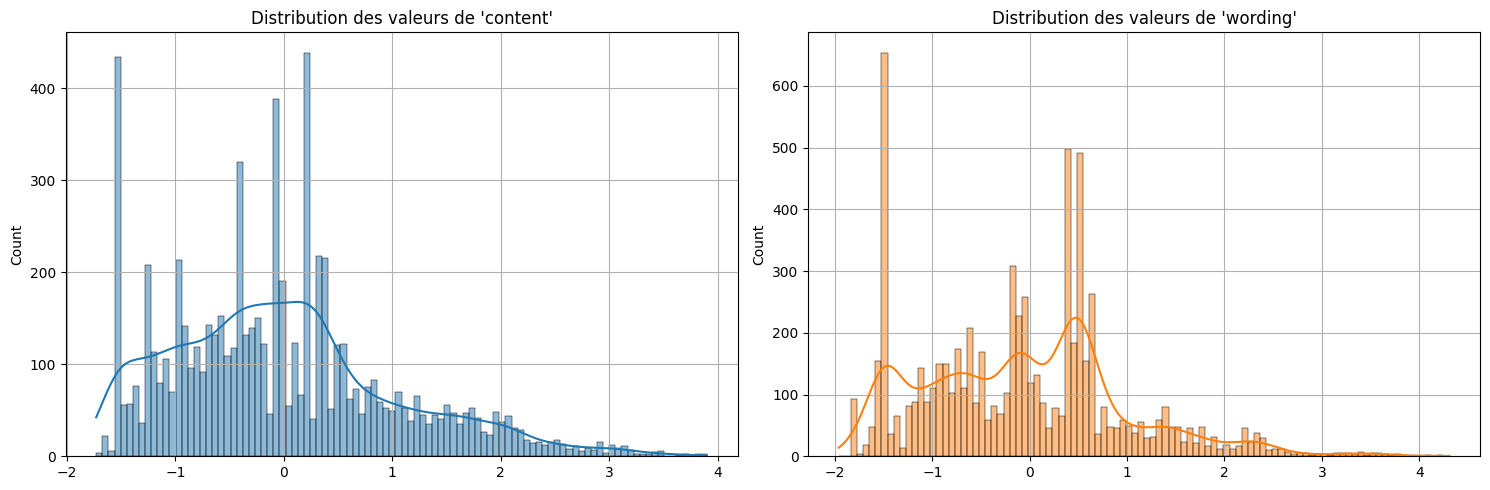

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i, target in enumerate(TARGETS):
    sns.histplot(df_train_summaries[target], bins=100, kde=True, fill=True, color=f'C{i}', ax=axs[i])
    axs[i].set_xlabel("")
    axs[i].set_title(f"Distribution des valeurs de '{target}'")
    axs[i].grid()

plt.tight_layout()
plt.show()

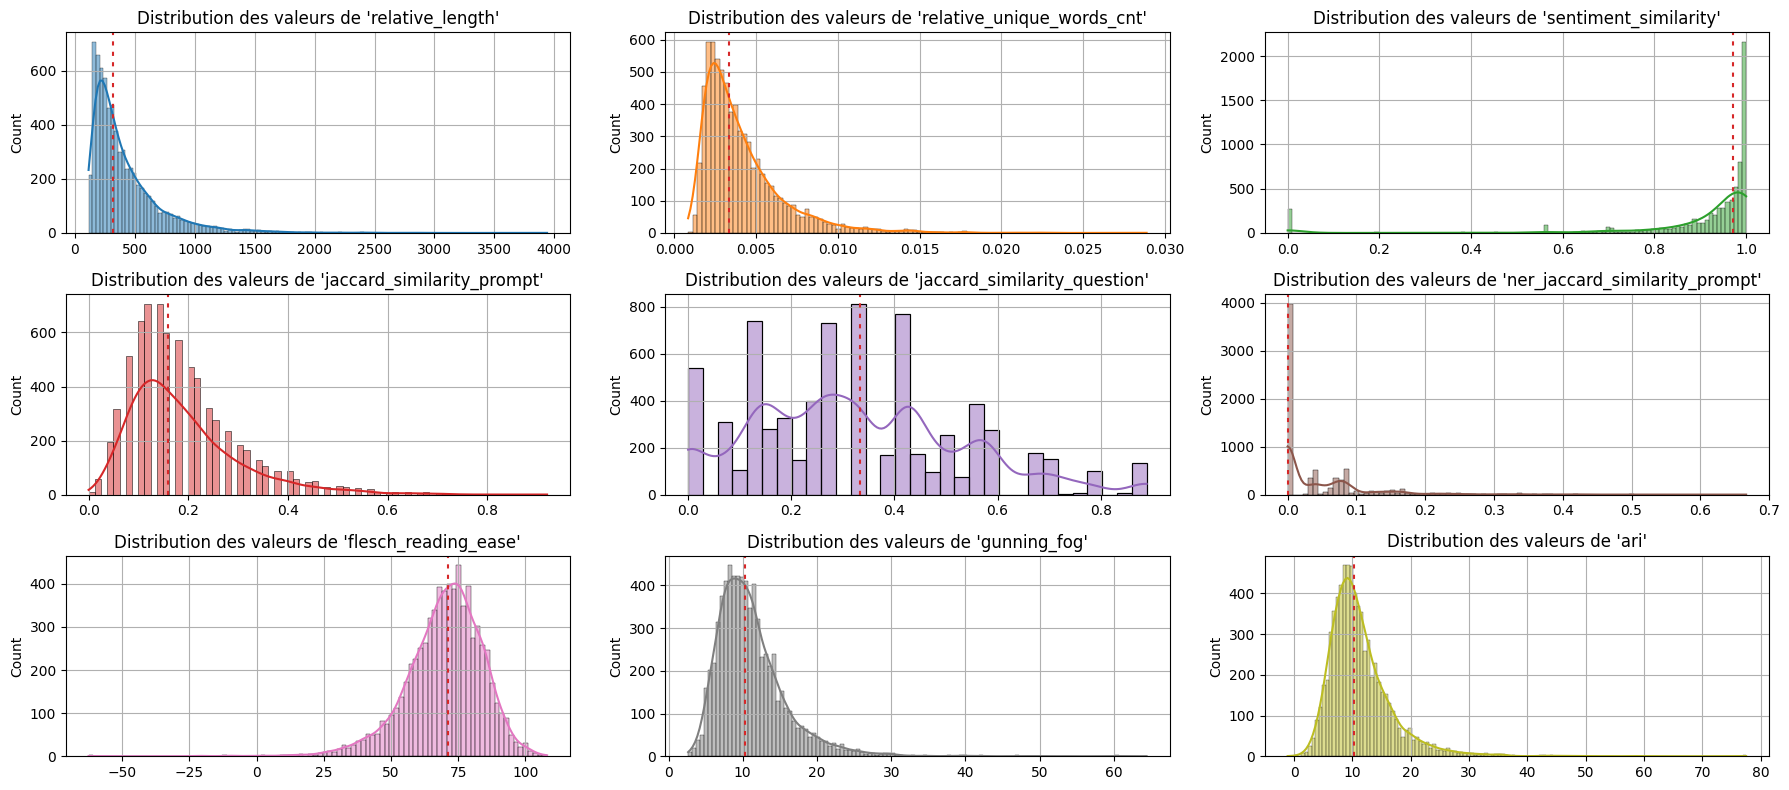

In [119]:
fig, axs = plt.subplots(3, 3, figsize=(18,8))

for i, feature in enumerate(FEATURES):
    row = i // 3
    col = i % 3
    sns.histplot(df_train_summaries[feature], fill=True, kde=True, color=f'C{i}', ax=axs[row, col],)
    axs[row, col].axvline(df_train_summaries[feature].median(), color='C3', linestyle='--', dashes=(2,3), label=f'Q50 ({round(df_train_summaries[feature].median(),3)})')
    axs[row, col].set_title(f"Distribution des valeurs de '{feature}'")
    axs[row, col].grid()
    axs[row, col].set_xlabel('')

plt.tight_layout()
plt.show()

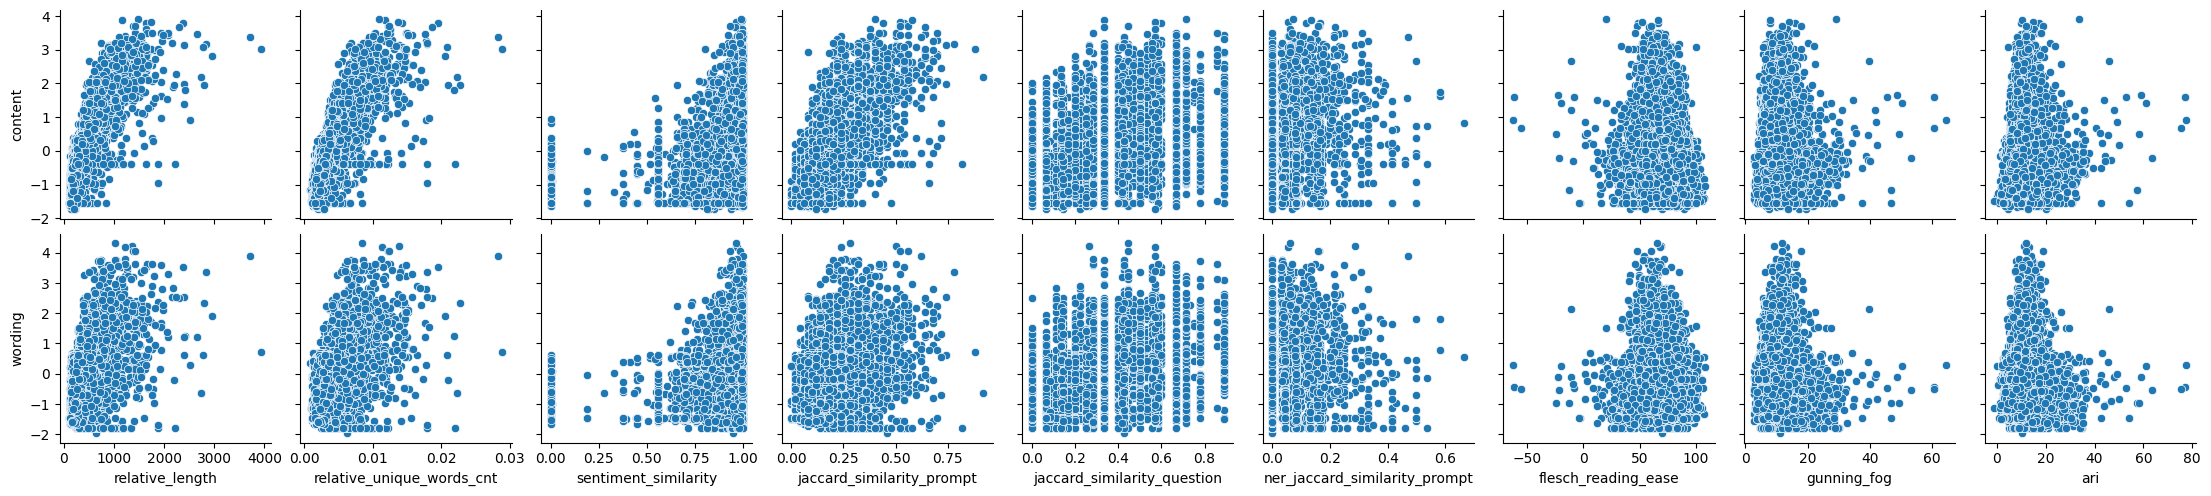

In [11]:
sns.pairplot(df_train_summaries[TARGETS + FEATURES], x_vars=FEATURES, y_vars=TARGETS);

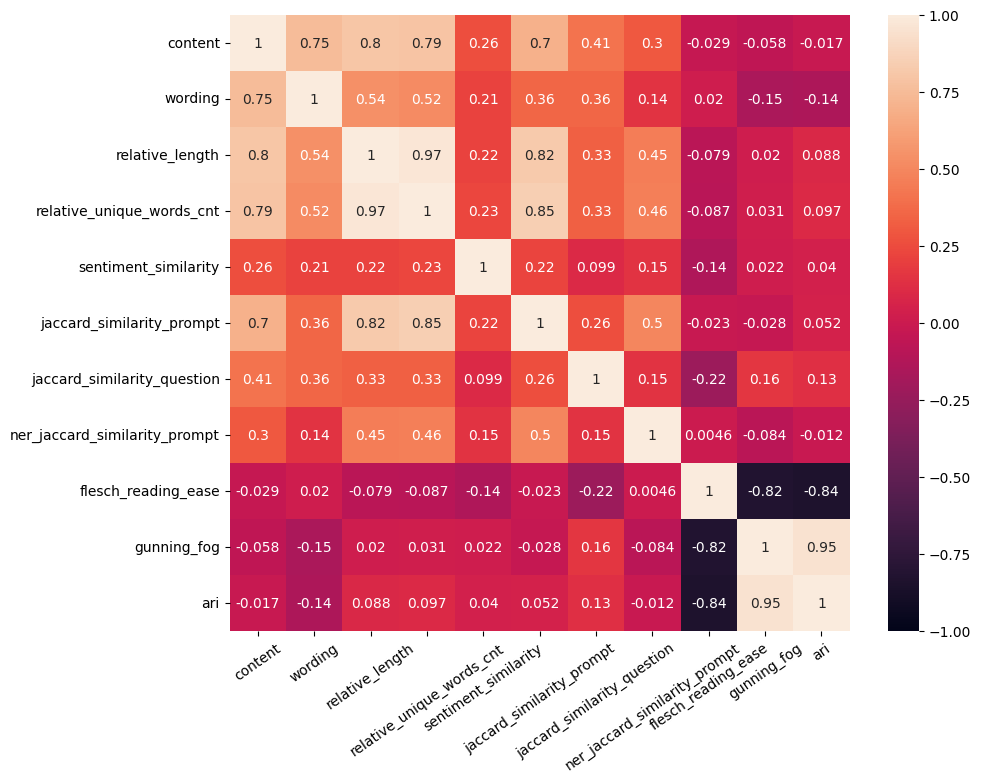

In [15]:
corr = df_train_summaries[TARGETS + FEATURES].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, vmin=-1)
plt.xticks(rotation=35);

In [16]:
df_train_summaries['readability'] = (df_train_summaries['gunning_fog'] + df_train_summaries['ari']) / 2

### **Feature selection for content**

| Feature | Selected | Reason |
|---------|----------|--------|
| relative_length | **YES** | This feature has the highest correlation coefficient with content (0.8). The length of a summary relative to the text it summarizes is a great indicator of the quality of a summary (wether the summary is too short or too long) |
| relative_unique_words_count | **NO** | While having a very high correlation coefficient with content (0.79), it's extremely correlated to relative_length (0.97) which has a higher correlation coefficient with content (0.8) |
| sentiment_similarity | **YES** | This feature is somewhat correlated to content (0.26) and a good summary should probably generally transcribe the sentiment of the text |
| jaccard_similarity_prompt | **YES** | This feature is highly correlated to content (0.7). While very correlated to relative_length (0.82), it could provide additional information |
| jaccard_similarity_question | **YES** | This feature is relatively correlated to content (0.41). Its purpose is to evaluate whether the summary answers the prompt question or not |
| ner_jaccard_similarity_prompt | **YES** | This feature is relatively correlated to content (0.3). Its purpose is to evaluate whether the summary contains the main entities in the text |
| flesch_reading_ease | **NO** | The readability features aren't correlated to content |
| gunning_fog | **NO** | The readability features aren't correlated to content |
| ari | **NO** | The readability features aren't correlated to content |
| readability | **NO** | The readability features aren't correlated to content |

### **Feature selection for wording**

| Feature | Selected | Reason |
|---------|----------|--------|
| relative_length | **YES** | This feature has the highest correlation coefficient with wording (0.54). The length of a summary relative to the text it summarizes is a great indicator of the quality of a summary (wether the summary is too short or too long) |
| relative_unique_words_count | **NO** | While having a high correlation coefficient with wording (0.52), it's extremely correlated to relative_length (0.97) which has a higher correlation coefficient with wording (0.54) |
| sentiment_similarity | **YES** | This feature is somewhat correlated to wording (0.21) and a good summary should probably generally transcribe the sentiment of the text |
| jaccard_similarity_prompt | **YES** | This feature is highly correlated to wording (0.36). While very correlated to relative_length (0.82), it could provide additional information |
| jaccard_similarity_question | **YES** | This feature is relatively correlated to wording (0.36). Its purpose is to evaluate whether the summary answers the prompt question or not |
| ner_jaccard_similarity_prompt | **YES** | This feature is somewhat correlated to wording (0.14). Its purpose is to evaluate whether the summary contains the main entities in the text |
| flesch_reading_ease | **NO** | This feature isn't correlated to wordind (0.02) |
| gunning_fog | **NO** | This feature is somewhat correlated to wording (-0.15) but will be used to create the readability feature |
| ari | **NO** | This feature is somewhat correlated to wording (-0.14) but will be used to create the readability feature |
| readability | **YES** | This feature is the mean value of gunning_fog and ari. Both these features are somewhat correlated to wording but are also extremely correlated to each other (0.95) and have a similar scale |

In [17]:
FEATURES_CONTENT = [
    'relative_length',
    'jaccard_similarity_prompt',
    'jaccard_similarity_question',
    'ner_jaccard_similarity_prompt',
    'sentiment_similarity'
    ]

FEATURES_WORDING = [
    'relative_length',
    'jaccard_similarity_prompt',
    'jaccard_similarity_question',
    'ner_jaccard_similarity_prompt',
    'sentiment_similarity',
    'readability'
    ]

# **Testing models**

In [18]:
def scale_features(df_train: pd.DataFrame, features: list[str], scaler=MinMaxScaler(), df_test: pd.DataFrame = None) -> pd.DataFrame:
    scaler.fit(df_train[features])
    df_to_fit = df_test.reset_index(drop=True) if isinstance(df_test, pd.DataFrame) else df_train.reset_index(drop=True)
    df_to_fit[features] = pd.DataFrame(scaler.transform(df_to_fit[features])).rename(columns={i : column for i, column in enumerate(df_to_fit[features].columns)})
    return df_to_fit

def plot_oob_rmse(model_content: tfdf.keras.RandomForestModel, model_wording: tfdf.keras.RandomForestModel) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    for i, model in enumerate([model_content, model_wording]):
        logs = model.make_inspector().training_logs()
        axs[i].plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
        axs[i].set_xlabel("Number of trees")
        axs[i].set_ylabel("RMSE (out-of-bag)")
        axs[i].set_title('Model ' + ('wording' if i else 'content'))
        axs[i].grid()
    plt.tight_layout()
    plt.show()

def calculate_r2(mse: float, target: pd.Series) -> float:
    target_mean = np.mean(target)
    total_sum_of_squares = np.sum((target - target_mean) ** 2)
    r_squared = 1 - (mse*len(target) / total_sum_of_squares)
    return r_squared

## **I. Using only the selected features**

#### For reference, here are the results obtained by the original models:

| Metric | Content | Wording |
|--------|----------|--------|
| **mse** | 0.2772 | 0.6162 |
| **rmse** | 0.5265 | 0.7850 |
| **R²** | 0.7513 | 0.4123 |

### 1. Train-Test split and feature scaling

In [19]:
train_summaries, test_summaries = train_test_split(df_train_summaries, test_size=0.2, random_state=42)

train_content_scaled = scale_features(train_summaries, FEATURES_CONTENT)[['content'] + FEATURES_CONTENT]
test_content_scaled = scale_features(train_summaries, FEATURES_CONTENT, df_test=test_summaries)[['content'] + FEATURES_CONTENT]

train_wording_scaled = scale_features(train_summaries, FEATURES_WORDING)[['wording'] + FEATURES_WORDING]
test_wording_scaled = scale_features(train_summaries, FEATURES_WORDING, df_test=test_summaries)[['wording'] + FEATURES_WORDING]

### 2. **Attempt 1.1:** Using the same model as the original (Random Forest)

- #### **Content model**

In [20]:
content_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_content_scaled, label='content', task = tfdf.keras.Task.REGRESSION)
model_content = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
model_content.compile(metrics=["mse"])
model_content.fit(x=content_train_ds)


inspector_content = model_content.make_inspector()
print(inspector_content.evaluation(), '\n')

content_test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_content_scaled, label="content", task = tfdf.keras.Task.REGRESSION)

evaluation_content = model_content.evaluate(x=content_test_ds,return_dict=True)
for name, value in evaluation_content.items():
    print(f"{name}: {value:.4f}")
    if name == 'mse':
        print(f"rmse: {value**0.5:.4f}")

r2_content = calculate_r2(evaluation_content['mse'], test_summaries['content'])
print(f"R²: {round(r2_content, 4)}")

inspector_content.variable_importances()["NUM_AS_ROOT"]

2024-02-15 09:58:45.608977: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Use /tmp/tmpdb6xpfmr as temporary training directory
Reading training dataset...


2024-02-15 09:58:45.615336: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-15 09:58:45.615379: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-15 09:58:45.620750: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-15 09:58:45.620802: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-15 09:58:45.620822: I external/local_xla/xla/stream_executor

Training dataset read in 0:00:03.547639. Found 5732 examples.
Training model...


[INFO 24-02-15 09:58:50.5452 CET kernel.cc:1233] Loading model from path /tmp/tmpdb6xpfmr/model/ with prefix b8bb094ef2e14fcb


Model trained in 0:00:01.463820
Compiling model...


[INFO 24-02-15 09:58:51.0333 CET decision_forest.cc:660] Model loaded with 300 root(s), 499340 node(s), and 5 input feature(s).
[INFO 24-02-15 09:58:51.0333 CET abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-02-15 09:58:51.0334 CET kernel.cc:1061] Use fast generic engine


Model compiled.
Evaluation(num_examples=5732, accuracy=None, loss=None, rmse=0.5026052636049675, ndcg=None, aucs=None, auuc=None, qini=None) 

2/2 [==============================] - 1s 24ms/step - loss: 0.0000e+00 - mse: 0.2366
loss: 0.0000
mse: 0.2366
rmse: 0.4864
R²: 0.7852


[("relative_length" (1; #4), 186.0),
 ("jaccard_similarity_prompt" (1; #1), 90.0),
 ("jaccard_similarity_question" (1; #2), 24.0)]

- #### **Wording model**

In [21]:
wording_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_wording_scaled, label='wording', task = tfdf.keras.Task.REGRESSION)
model_wording = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
model_wording.compile(metrics=["mse"])
model_wording.fit(x=wording_train_ds)

inspector_wording = model_wording.make_inspector()
print(inspector_wording.evaluation(), '\n')

wording_test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_wording_scaled, label="wording", task = tfdf.keras.Task.REGRESSION)

evaluation_wording = model_wording.evaluate(x=wording_test_ds,return_dict=True)
for name, value in evaluation_wording.items():
    print(f"{name}: {value:.4f}")
    if name == 'mse':
        print(f"rmse: {value**0.5:.4f}")

r2_wording = calculate_r2(evaluation_wording['mse'], test_summaries['wording'])
print(f"R²: {round(r2_wording, 4)}")

inspector_wording.variable_importances()["NUM_AS_ROOT"]

Use /tmp/tmpqz6mos_z as temporary training directory
Reading training dataset...


Training dataset read in 0:00:00.146179. Found 5732 examples.
Training model...


[INFO 24-02-15 09:58:53.7428 CET kernel.cc:1233] Loading model from path /tmp/tmpqz6mos_z/model/ with prefix e2975344ba2144e5


Model trained in 0:00:01.294729
Compiling model...


[INFO 24-02-15 09:58:54.1699 CET decision_forest.cc:660] Model loaded with 300 root(s), 473352 node(s), and 6 input feature(s).
[INFO 24-02-15 09:58:54.1700 CET kernel.cc:1061] Use fast generic engine


Model compiled.
Evaluation(num_examples=5732, accuracy=None, loss=None, rmse=0.6884255648866541, ndcg=None, aucs=None, auuc=None, qini=None) 

2/2 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - mse: 0.4668
loss: 0.0000
mse: 0.4668
rmse: 0.6832
R²: 0.5446


[("relative_length" (1; #5), 149.0),
 ("jaccard_similarity_prompt" (1; #1), 71.0),
 ("jaccard_similarity_question" (1; #2), 60.0),
 ("ner_jaccard_similarity_prompt" (1; #3), 17.0),
 ("readability" (1; #4), 3.0)]

- #### **Results**

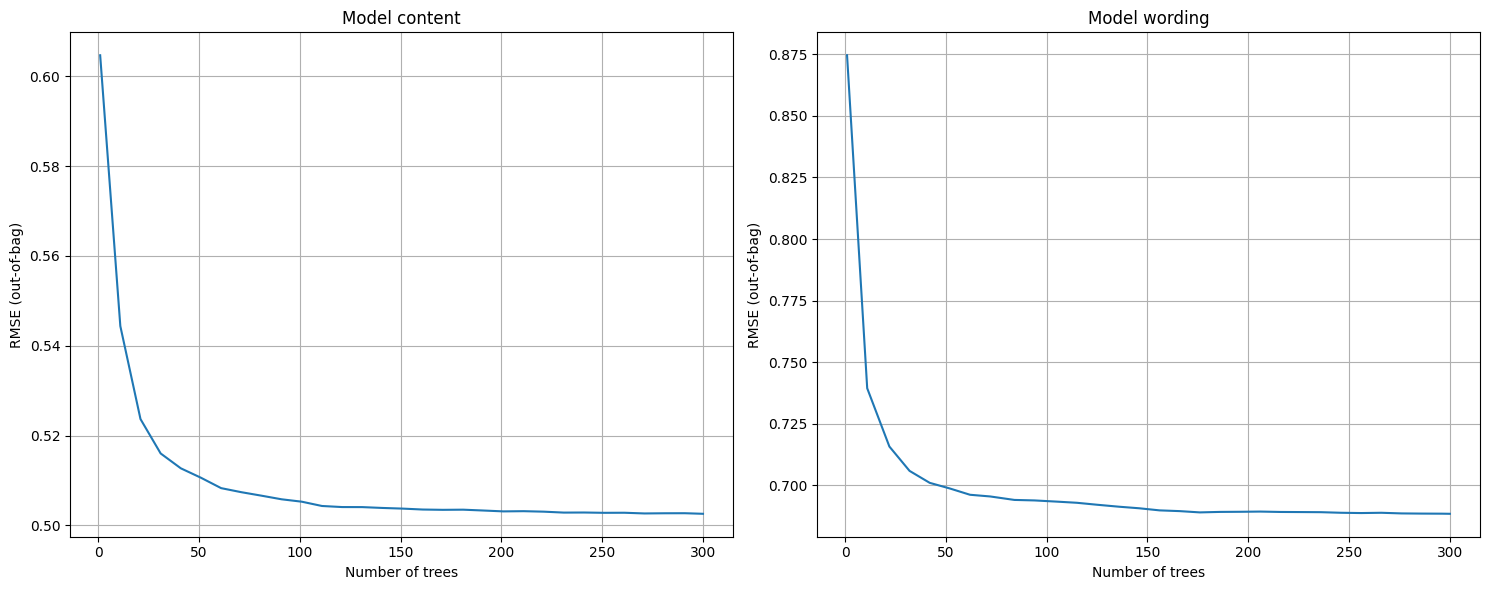

In [19]:
plot_oob_rmse(model_content, model_wording)

#### Using the same models, we can already see some improvement for both content and wording

| RMSE    | original (RF) | attempt 1.1 (RF) | R²      | original (RF) | attempt 1.1 (RF) |
|:-------:|:-------------:|:----------------:|:-------:|:-------------:|:----------------:|
| content | 0.5265        | **0.4864**       | content | 0.7513        | **0.7852**       |
| wording | 0.7850        | **0.6832**       | wording | 0.4123        | **0.5446**       |

### 3. **Attempt 1.2:** Using XGBoost

- #### **Content model**

In [20]:
model_content_xgb = XGBRegressor(objective='reg:squarederror', colsample_bytree=1, learning_rate=0.01, max_depth=7, n_estimators=700, subsample=0.5)
r2_scores = cross_val_score(model_content_xgb, train_content_scaled.drop(columns='content'), train_content_scaled['content'], cv=5)

print("Cross-validation R² scores: ", r2_scores)
print("Average cross-validation R² score: ", round(r2_scores.mean(), 4))

model_content_xgb.fit(train_content_scaled.drop(columns='content'), train_content_scaled['content'])
predictions_content = model_content_xgb.predict(test_content_scaled.drop(columns='content'))
mse_valid_content = mean_squared_error(test_content_scaled['content'], predictions_content)
r2_valid_content = calculate_r2(mse_valid_content, test_content_scaled['content'])

print(f"""
Validation MSE: {round(mse_valid_content, 4)}
Validation RMSE: {round(mse_valid_content**0.5, 4)}
Validation R²: {round(r2_valid_content, 4)}
""")

Cross-validation R² scores:  [0.7655896  0.76794733 0.77103257 0.75785227 0.77713563]
Average cross-validation R² score:  0.7679

Validation MSE: 0.2305
Validation RMSE: 0.4801
Validation R²: 0.7907



- #### **Wording model**

In [21]:
model_wording_xgb = XGBRegressor(objective='reg:squarederror', colsample_bytree=1, learning_rate=0.01, max_depth=7, n_estimators=700, subsample=0.5)
r2_scores = cross_val_score(model_wording_xgb, train_wording_scaled.drop(columns='wording'), train_wording_scaled['wording'], cv=5)

print("Cross-validation R² scores: ", r2_scores)
print("Average cross-validation R² score: ", round(r2_scores.mean(), 4))

model_wording_xgb.fit(train_wording_scaled.drop(columns='wording'), train_wording_scaled['wording'])
predictions_wording = model_wording_xgb.predict(test_wording_scaled.drop(columns='wording'))
mse_valid_wording = mean_squared_error(test_wording_scaled['wording'], predictions_wording)
r2_valid_wording = calculate_r2(mse_valid_wording, test_wording_scaled['wording'])

print(f"""
Validation MSE: {round(mse_valid_wording, 4)}
Validation RMSE: {round(mse_valid_wording**0.5, 4)}
Validation R²: {round(r2_valid_wording, 4)}
""")

Cross-validation R² scores:  [0.58070871 0.56726718 0.56220239 0.54740976 0.59547429]
Average cross-validation R² score:  0.5706

Validation MSE: 0.4402
Validation RMSE: 0.6635
Validation R²: 0.5705



- #### **Results**

#### Using XGBoost rather than a Random Forest slightly improves the results

| RMSE    | original (RF) | attempt 1.1 (RF) | attempt 1.2 (XGB)  | R²      | original (RF) | attempt 1.1 (RF) | attempt 1.2 (XGB) |
|:-------:|:-------------:|:----------------:|:------------------:|:-------:|:-------------:|:----------------:|:-----------------:|
| content | 0.5265        | 0.4864           | **0.4801**         | content | 0.7513        | 0.7852           | **0.7907**        |
| wording | 0.7850        | 0.6832           | **0.6635**         | wording | 0.4123        | 0.5446           | **0.5705**        |

## **II. Adding new features with TF-IDF and TruncateSVD**

### 1. Creating the new features

In order improve the performance of the models (mostly for wording), we will now create some new features by following these steps:
- combine the prompt and prompt question (that we will now simply refer to as prompt),
- tokenize every prompt and summary and extract the tags,
- fit a TfidfVectorizer with the entire corpus (prompts and summaries),
- transform into vectors the tokenized summaries using the previously fitted TfidfVectorizer.

Then for both content and wording separately:
- use TruncateSVD to dimensionally reduce the size of the vectors to a set number of components *n*,
- find which have a correlation coefficient with the target above a set threshold,
- include then as features in the new models.

In [22]:
def tokenize(text: str) -> str:
    return ' '.join([tag for word, tag in nltk.pos_tag(nltk.word_tokenize(text))])


def tfidf_vectorizer(df_prompt: pd.DataFrame, df_summaries: pd.DataFrame) -> dict[TfidfVectorizer]:
    texts = df_prompt['tokens'].tolist() + df_summaries['tokens'].tolist()
    vectorizer_tfidf = TfidfVectorizer(ngram_range=(4,4))
    vectorizer_tfidf.fit(texts)
    return vectorizer_tfidf


def tfidf(text: str, vectorizer_tfidf: TfidfVectorizer) -> np.ndarray:
    vectors = vectorizer_tfidf.transform([text])
    return vectors


def tfidf_reductor(df: pd.DataFrame, target: str, n_components: int = 50) -> TruncatedSVD:
    tfidf_matrix = vstack(df['tfidf_vector'].values.tolist())
    svd = TruncatedSVD(n_components=n_components)
    svd.fit(tfidf_matrix, df[target])
    return svd


def vector_to_df(df: pd.DataFrame, reductor: TruncatedSVD) -> pd.DataFrame:
    reduced_vectors = reductor.transform(vstack(df['tfidf_vector'].values.tolist()))
    return pd.DataFrame(reduced_vectors)


def tfidf_to_features(df: pd.DataFrame, target: str, threshold: float = 0.05, n_components=500) -> pd.DataFrame:
    reductor = tfidf_reductor(df, target, n_components=n_components)
    df_reduced = pd.concat([df[[target]], vector_to_df(df_train_summaries, reductor)], axis=1).rename(columns={i : str(i) for i in range(n_components)})
    corr = df_reduced[[target] + [str(i) for i in range(n_components)]].corr()
    corr = corr[target].drop(target).to_frame()
    corr = corr[corr[target].abs() >= threshold]
    selected_components = corr.index.tolist()
    df_filtered = pd.concat([df, df_reduced[selected_components]], axis=1)
    return df_filtered, selected_components

In [23]:
df_train_prompt['tokens'] = (df_train_prompt['prompt_question'] + '\n' + df_train_prompt['prompt']).apply(tokenize)
df_train_summaries['tokens'] = df_train_summaries['text'].apply(tokenize)
vectorizer_tfidf = tfidf_vectorizer(df_train_prompt, df_train_summaries)
df_train_summaries['tfidf_vector'] = df_train_summaries['tokens'].apply(lambda x: tfidf(x, vectorizer_tfidf))

- #### **Content features**

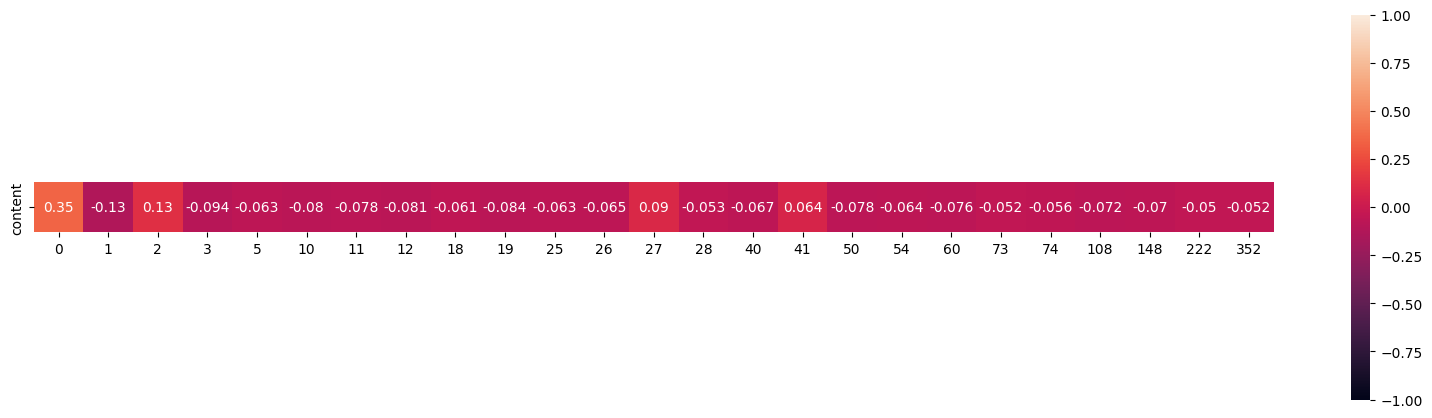

,student_id,prompt_id,text,content,wording,word_cnt,length,relative_length,stopword_cnt,punct_cnt,number_cnt,text_lemmatized,unique_words_cnt,relative_unique_words_cnt,unique_words_ratio,text_vector_text,text_vector_question,jaccard_similarity_prompt,jaccard_similarity_question,text_ner,ner_jaccard_similarity_prompt,flesch_reading_ease,gunning_fog,ari,sentiment_similarity,readability,tokens,tfidf_vector,0,1,2,3,5,10,11,12,18,19,25,26,27,28,40,41,50,54,60,73,74,108,148,222,352
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,61,346,346.0,0.409836,0.049180,0.0,"[third, wave, experimentto, see, people, react...",30,0.004187,0.491803,"[[0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 1, 0, 1]]",0.12,0.222222,"[(third, ORDINAL), (one, CARDINAL)]",0.032258,64.41,9.4,8.3,0.885801,8.85,DT JJ NN VBD DT JJ VB WRB NNS VBD TO DT JJ CD ...,"(0, 43485)\t0.14800098294160904\n (0, 42525...",0.043984,-0.010735,0.023957,-0.011327,-0.037265,0.024941,-0.006874,-0.007654,0.016107,-0.015319,-0.009048,-0.036698,0.001538,-0.015791,0.019119,-0.001340,0.001976,-0.031866,0.003595,-0.003035,0.026282,0.027000,-0.007925,0.011077,-0.005835
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,52,244,244.0,0.576923,0.038462,0.0,"[would, rub, soda, make, smell, away, wouldnt,...",15,0.002094,0.288462,"[[3, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3]]",0.08,0.166667,[],0.000000,87.39,10.4,9.0,0.693883,9.70,PRP MD VB PRP RP IN NN TO VB DT NN VB RB CC PR...,"(0, 43249)\t0.21670657114088338\n (0, 37648...",0.153397,0.046981,-0.034136,-0.000888,-0.034344,0.052234,0.012921,0.024524,-0.020592,-0.001714,0.009710,0.016881,-0.010217,-0.008466,0.030834,-0.016857,-0.010610,-0.006474,-0.007616,0.032132,-0.020220,0.013201,-0.034494,-0.038281,0.028582


In [24]:
df_train_summaries_content, selected_components_content = tfidf_to_features(df_train_summaries, 'content')

plt.figure(figsize=(20,5))
sns.heatmap(df_train_summaries_content[['content'] + selected_components_content].corr()['content'].drop('content').to_frame().T, annot=True, vmin=-1, vmax=1, square=True)
plt.show()

df_train_summaries_content.head(2)

- #### **Wording features**

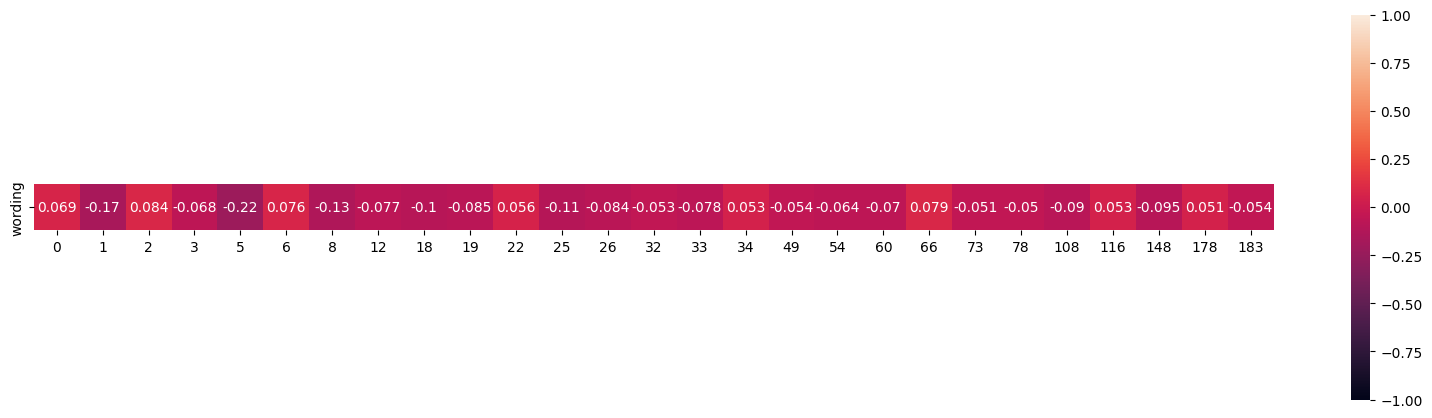

,student_id,prompt_id,text,content,wording,word_cnt,length,relative_length,stopword_cnt,punct_cnt,number_cnt,text_lemmatized,unique_words_cnt,relative_unique_words_cnt,unique_words_ratio,text_vector_text,text_vector_question,jaccard_similarity_prompt,jaccard_similarity_question,text_ner,ner_jaccard_similarity_prompt,flesch_reading_ease,gunning_fog,ari,sentiment_similarity,readability,tokens,tfidf_vector,0,1,2,3,5,6,8,12,18,19,22,25,26,32,33,34,49,54,60,66,73,78,108,116,148,178,183
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,61,346,346.0,0.409836,0.049180,0.0,"[third, wave, experimentto, see, people, react...",30,0.004187,0.491803,"[[0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 1, 0, 1]]",0.12,0.222222,"[(third, ORDINAL), (one, CARDINAL)]",0.032258,64.41,9.4,8.3,0.885801,8.85,DT JJ NN VBD DT JJ VB WRB NNS VBD TO DT JJ CD ...,"(0, 43485)\t0.14800098294160904\n (0, 42525...",0.043984,-0.010735,0.023957,-0.011327,-0.037265,0.049991,-0.007622,-0.007654,0.016108,-0.015318,0.003194,-0.009045,-0.036699,-0.004186,-0.030062,0.012572,-0.002810,-0.031867,0.003610,0.022364,-0.002982,-0.011484,0.027355,-0.001418,-0.007866,0.010444,0.020294
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,52,244,244.0,0.576923,0.038462,0.0,"[would, rub, soda, make, smell, away, wouldnt,...",15,0.002094,0.288462,"[[3, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3]]",0.08,0.166667,[],0.000000,87.39,10.4,9.0,0.693883,9.70,PRP MD VB PRP RP IN NN TO VB DT NN VB RB CC PR...,"(0, 43249)\t0.21670657114088338\n (0, 37648...",0.153397,0.046981,-0.034136,-0.000888,-0.034344,-0.013255,-0.022598,0.024525,-0.020593,-0.001713,0.007595,0.009711,0.016882,-0.009406,-0.037532,-0.014483,-0.035178,-0.006464,-0.007612,0.025918,0.032104,0.029413,0.012902,0.015720,-0.034189,0.026282,0.017568


In [25]:
df_train_summaries_wording, selected_components_wording = tfidf_to_features(df_train_summaries, 'wording')

plt.figure(figsize=(20,5))
sns.heatmap(df_train_summaries_wording[['wording'] + selected_components_wording].corr()['wording'].drop('wording').to_frame().T, annot=True, vmin=-1, vmax=1, square=True)
plt.show()

df_train_summaries_wording.head(2)

### 2. **Attempt 2.1:** Using the same model as the original (Random Forest)

- #### **Content model**

In [26]:
cols_content = ['content'] + FEATURES_CONTENT + selected_components_content
train_content_2, test_content_2 = train_test_split(df_train_summaries_content[cols_content], test_size=0.2, random_state=42)
train_content_scaled_2 = scale_features(train_content_2, FEATURES_CONTENT)
test_content_scaled_2 = scale_features(train_content_2, FEATURES_CONTENT, df_test=test_content_2)

content_train_ds_2 = tfdf.keras.pd_dataframe_to_tf_dataset(train_content_scaled_2, label='content', task = tfdf.keras.Task.REGRESSION)
model_content_2 = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
model_content_2.compile(metrics=["mse"])
model_content_2.fit(x=content_train_ds_2)


inspector_content = model_content_2.make_inspector()
print(inspector_content.evaluation(), '\n')

content_test_ds_2 = tfdf.keras.pd_dataframe_to_tf_dataset(test_content_scaled_2, label="content", task = tfdf.keras.Task.REGRESSION)

evaluation_content = model_content_2.evaluate(x=content_test_ds_2,return_dict=True)
for name, value in evaluation_content.items():
    print(f"{name}: {value:.4f}")
    if name == 'mse':
        print(f"rmse: {value**0.5:.4f}")

r2_content = calculate_r2(evaluation_content['mse'], test_summaries['content'])
print(f"R²: {round(r2_content, 4)}")

inspector_content.variable_importances()["NUM_AS_ROOT"]

Use /tmp/tmpf67lvtet as temporary training directory
Reading training dataset...


Training dataset read in 0:00:00.329418. Found 5732 examples.
Training model...


[INFO 24-02-15 09:59:48.3505 CET kernel.cc:1233] Loading model from path /tmp/tmpf67lvtet/model/ with prefix 5f414d09947a4bc8


Model trained in 0:00:01.913659
Compiling model...


[INFO 24-02-15 09:59:48.7725 CET decision_forest.cc:660] Model loaded with 300 root(s), 485216 node(s), and 30 input feature(s).
[INFO 24-02-15 09:59:48.7725 CET abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-02-15 09:59:48.7726 CET kernel.cc:1061] Use fast generic engine


Model compiled.
Evaluation(num_examples=5732, accuracy=None, loss=None, rmse=0.464522538436615, ndcg=None, aucs=None, auuc=None, qini=None) 

2/2 [==============================] - 0s 29ms/step - loss: 0.0000e+00 - mse: 0.2098
loss: 0.0000
mse: 0.2098
rmse: 0.4580
R²: 0.8095


[("relative_length" (1; #29), 104.0),
 ("jaccard_similarity_prompt" (1; #26), 76.0),
 ("jaccard_similarity_question" (1; #27), 49.0),
 ("ner_jaccard_similarity_prompt" (1; #28), 23.0),
 ("0" (1; #0), 20.0),
 ("1" (1; #1), 13.0),
 ("sentiment_similarity" (1; #30), 6.0),
 ("2" (1; #9), 5.0),
 ("5" (1; #19), 3.0),
 ("27" (1; #13), 1.0)]

- #### **Wording model**

In [27]:
cols_wording = ['wording'] + FEATURES_WORDING + selected_components_wording
train_wording_2, test_wording_2 = train_test_split(df_train_summaries_wording[cols_wording], test_size=0.2, random_state=42)
train_wording_scaled_2 = scale_features(train_wording_2, FEATURES_WORDING)
test_wording_scaled_2 = scale_features(train_wording_2, FEATURES_WORDING, df_test=test_wording_2)

wording_train_ds_2 = tfdf.keras.pd_dataframe_to_tf_dataset(train_wording_scaled_2, label='wording', task = tfdf.keras.Task.REGRESSION)
model_wording_2 = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
model_wording_2.compile(metrics=["mse"])
model_wording_2.fit(x=wording_train_ds_2)


inspector_wording = model_wording_2.make_inspector()
print(inspector_wording.evaluation(), '\n')

wording_test_ds_2 = tfdf.keras.pd_dataframe_to_tf_dataset(test_wording_scaled_2, label="wording", task = tfdf.keras.Task.REGRESSION)

evaluation_wording = model_wording_2.evaluate(x=wording_test_ds_2,return_dict=True)
for name, value in evaluation_wording.items():
    print(f"{name}: {value:.4f}")
    if name == 'mse':
        print(f"rmse: {value**0.5:.4f}")

r2_wording = calculate_r2(evaluation_wording['mse'], test_summaries['wording'])
print(f"R²: {round(r2_wording, 4)}")

inspector_wording.variable_importances()["NUM_AS_ROOT"]

Use /tmp/tmpxt21uble as temporary training directory
Reading training dataset...


Training dataset read in 0:00:00.411015. Found 5732 examples.
Training model...


[INFO 24-02-15 09:59:51.4044 CET kernel.cc:1233] Loading model from path /tmp/tmpxt21uble/model/ with prefix 5b1b908236ba4425


Model trained in 0:00:01.886091
Compiling model...


[INFO 24-02-15 09:59:51.8165 CET decision_forest.cc:660] Model loaded with 300 root(s), 442468 node(s), and 33 input feature(s).
[INFO 24-02-15 09:59:51.8165 CET kernel.cc:1061] Use fast generic engine


Model compiled.
Evaluation(num_examples=5732, accuracy=None, loss=None, rmse=0.6266588531940118, ndcg=None, aucs=None, auuc=None, qini=None) 

2/2 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - mse: 0.3685
loss: 0.0000
mse: 0.3685
rmse: 0.6071
R²: 0.6404


[("relative_length" (1; #32), 116.0),
 ("jaccard_similarity_prompt" (1; #28), 75.0),
 ("jaccard_similarity_question" (1; #29), 35.0),
 ("ner_jaccard_similarity_prompt" (1; #30), 25.0),
 ("5" (1; #19), 16.0),
 ("readability" (1; #31), 14.0),
 ("sentiment_similarity" (1; #33), 10.0),
 ("2" (1; #10), 5.0),
 ("18" (1; #7), 2.0),
 ("1" (1; #1), 1.0),
 ("12" (1; #4), 1.0)]

- #### **Results**

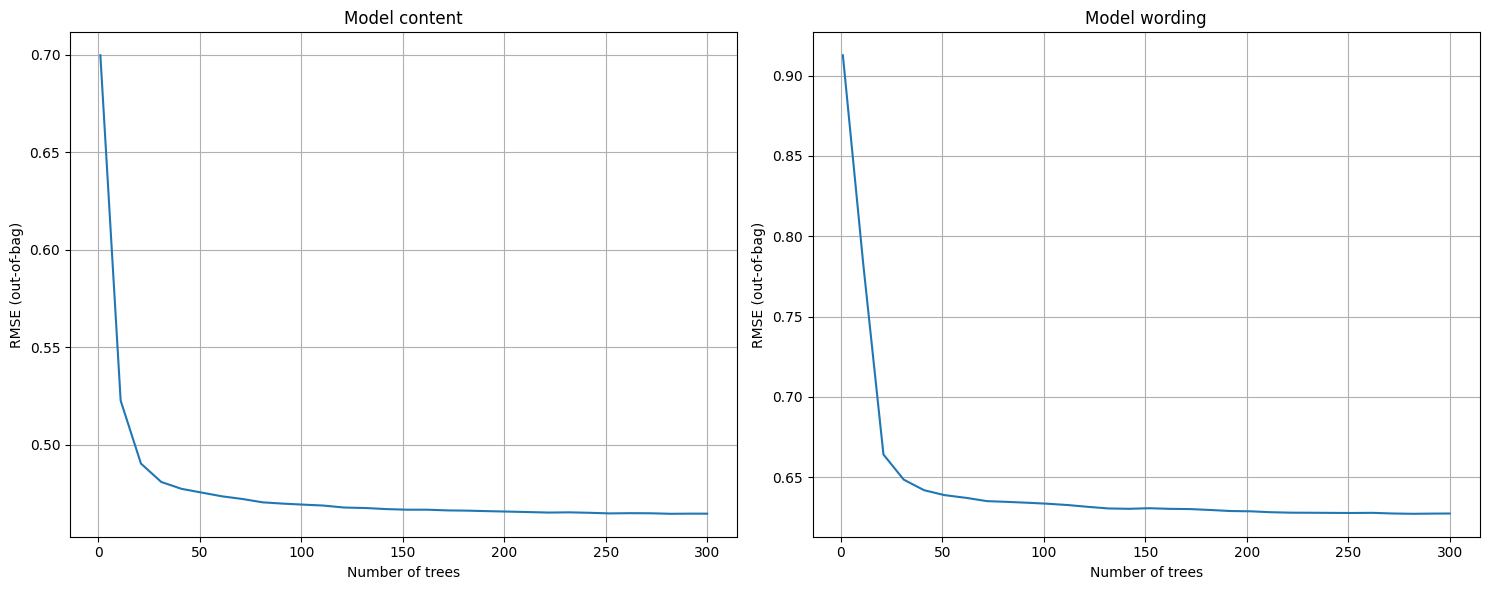

In [28]:
plot_oob_rmse(model_content_2, model_wording_2)

### 3. **Attempt 2.2:** Using XGBoost

- #### **Content model**

In [28]:
model_content_xgb_2 = XGBRegressor(objective='reg:squarederror', colsample_bytree=1, learning_rate=0.01, max_depth=7, n_estimators=700, subsample=0.5)
r2_scores = cross_val_score(model_content_xgb_2, train_content_scaled_2.drop(columns='content'), train_content_scaled_2['content'], cv=5)

print("Cross-validation R² scores: ", r2_scores)
print("Average cross-validation R² score: ", round(r2_scores.mean(), 4))

model_content_xgb_2.fit(train_content_scaled_2.drop(columns='content'), train_content_scaled_2['content'])
predictions_content_2 = model_content_xgb_2.predict(test_content_scaled_2.drop(columns='content'))
mse_valid_content_2 = mean_squared_error(test_content_scaled_2['content'], predictions_content_2)
r2_valid_content_2 = calculate_r2(mse_valid_content_2, test_content_scaled_2['content'])

print(f"""
Validation MSE: {round(mse_valid_content_2, 4)}
Validation RMSE: {round(mse_valid_content_2**0.5, 4)}
Validation R²: {round(r2_valid_content_2, 4)}
""")

Cross-validation R² scores:  [0.80973918 0.80867514 0.81190911 0.79165283 0.80882006]
Average cross-validation R² score:  0.8062

Validation MSE: 0.198
Validation RMSE: 0.445
Validation R²: 0.8202



- #### **Wording model**

In [ ]:
model_wording_xgb_2 = XGBRegressor(objective='reg:squarederror', colsample_bytree=1, learning_rate=0.01, max_depth=7, n_estimators=700, subsample=0.5)
r2_scores = cross_val_score(model_wording_xgb_2, train_wording_scaled_2.drop(columns='wording'), train_wording_scaled_2['wording'], cv=5)

print("Cross-validation R² scores: ", r2_scores)
print("Average cross-validation R² score: ", round(r2_scores.mean(), 4))

model_wording_xgb_2.fit(train_wording_scaled_2.drop(columns='wording'), train_wording_scaled_2['wording'])
predictions_wording_2 = model_wording_xgb_2.predict(test_wording_scaled_2.drop(columns='wording'))
mse_valid_wording_2 = mean_squared_error(test_wording_scaled_2['wording'], predictions_wording_2)
r2_valid_wording_2 = calculate_r2(mse_valid_wording_2, test_wording_scaled_2['wording'])

print(f"""
Validation MSE: {round(mse_valid_wording_2, 4)}
Validation RMSE: {round(mse_valid_wording_2**0.5, 4)}
Validation R²: {round(r2_valid_wording_2, 4)}
""")

Cross-validation R² scores:  [0.67888254 0.65770817 0.66068444 0.63528677 0.66301331]
Average cross-validation R² score:  0.6591

Validation MSE: 0.3285
Validation RMSE: 0.5732
Validation R²: 0.6795



- #### **Results**

#### The new features improve the results on both types of models, XGBoost still get's the best overall scores.

| RMSE    | original (RF) | attempt 1.1 (RF) | attempt 1.2 (XGB) | attempt 2.1 (RF) | attempt 2.2 (XGB)  | R²      | original (RF) | attempt 1.1 (RF) | attempt 1.2 (XGB) | attempt 2.2 (RF) | attempt 2.2 (XGB) |
|:-------:|:-------------:|:----------------:|:-----------------:|:----------------:|:------------------:|:-------:|:-------------:|:----------------:|:-----------------:|:----------------:|:-----------------:|
| content | 0.5265        | 0.4864           | 0.4801            | 0.4567           | **0.4461**         | content | 0.7513        | 0.7852           | 0.7907            | 0.8106           | **0.8193**        |
| wording | 0.7850        | 0.6832           | 0.6635            | 0.6070           | **0.5728**         | wording | 0.4123        | 0.5446           | 0.5705            | 0.6405           | **0.6799**        |

## **III. GridSearchCV for optimal hyperparameters**

In [39]:
def gridsearch(df_train: pd.DataFrame, target: str, param_grid: dict, model=XGBRegressor(), cv=3) -> dict:
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, n_jobs=-1)
    grid_search.fit(df_train.drop(columns=target), df_train[target])
    best_params = grid_search.best_params_
    print(best_params)
    return best_params

- #### **Content model**

In [36]:
param_grid_content_1 = {
    'n_estimators': [500, 700, 900],
    'max_depth': [6, 7, 8],
    'learning_rate': [0.01, 0.02],
    'subsample': [0.4, 0.5, 0.6]
}

best_params_content_1 = gridsearch(train_content_scaled_2, 'content', param_grid_content_1)

{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 900, 'subsample': 0.6}


In [41]:
param_grid_content_2 = {
    'n_estimators': [800, 900, 1000],
    'max_depth': [5, 6],
    'learning_rate' : [0.01],
    'subsample': [0.6, 0.7],
}

best_params_content_2 = gridsearch(train_content_scaled_2, 'content', param_grid_content_2)

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.6}


In [42]:
param_grid_content_3 = {
    'n_estimators': [1000, 1100, 1200],
    'max_depth': [4, 5],
    'learning_rate' : [0.01],
    'subsample': [0.6],
}

best_params_content_3 = gridsearch(train_content_scaled_2, 'content', param_grid_content_3)

{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1200, 'subsample': 0.6}


In [43]:
param_grid_content_4 = {
    'n_estimators': [1200, 1300, 1400, 1500],
    'max_depth': [2, 3, 4],
    'learning_rate' : [0.01],
    'subsample': [0.6],
}

best_params_content_4 = gridsearch(train_content_scaled_2, 'content', param_grid_content_4)

{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1500, 'subsample': 0.6}


In [44]:
param_grid_content_5 = {
    'n_estimators': [1500, 1750, 2000],
    'max_depth': [4],
    'learning_rate' : [0.01],
    'subsample': [0.6],
}

best_params_content_5 = gridsearch(train_content_scaled_2, 'content', param_grid_content_5)

{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 2000, 'subsample': 0.6}


In [45]:
param_grid_content_6 = {
    'n_estimators': [2000, 2500, 3000],
    'max_depth': [4],
    'learning_rate' : [0.01],
    'subsample': [0.6],
}

best_params_content_6 = gridsearch(train_content_scaled_2, 'content', param_grid_content_6)

{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 2000, 'subsample': 0.6}


In [30]:
model_content_xgb_3 = XGBRegressor(objective='reg:squarederror', learning_rate=0.01, max_depth=4, n_estimators=2000, subsample=0.6)
r2_scores = cross_val_score(model_content_xgb_3, train_content_scaled_2.drop(columns='content'), train_content_scaled_2['content'], cv=5)

print("Cross-validation R² scores: ", r2_scores)
print("Average cross-validation R² score: ", round(r2_scores.mean(), 4))

model_content_xgb_3.fit(train_content_scaled_2.drop(columns='content'), train_content_scaled_2['content'])
predictions_content_3 = model_content_xgb_3.predict(test_content_scaled_2.drop(columns='content'))
mse_valid_content_3 = mean_squared_error(test_content_scaled_2['content'], predictions_content_3)
r2_valid_content_3 = calculate_r2(mse_valid_content_3, test_content_scaled_2['content'])

print(f"""
Validation MSE: {round(mse_valid_content_3, 4)}
Validation RMSE: {round(mse_valid_content_3**0.5, 4)}
Validation R²: {round(r2_valid_content_3, 4)}
""")

Cross-validation R² scores:  [0.81595518 0.81211745 0.81505027 0.79395843 0.81046683]
Average cross-validation R² score:  0.8095

Validation MSE: 0.1962
Validation RMSE: 0.443
Validation R²: 0.8218



- #### **Wording model**

In [37]:
param_grid_wording_1 = {
    'n_estimators': [500, 700, 900],
    'max_depth': [6, 7, 8],
    'learning_rate': [0.01, 0.02],
    'subsample': [0.4, 0.5, 0.6]
}

best_params_wording_1 = gridsearch(train_wording_scaled_2, 'wording', param_grid_wording_1)

{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 900, 'subsample': 0.4}


In [48]:
param_grid_wording_2 = {
    'n_estimators': [900, 1200, 1500],
    'max_depth': [3, 4, 5, 6],
    'learning_rate' : [0.01],
    'subsample': [0.2, 0.3, 0.4],
}

best_params_wording_2 = gridsearch(train_wording_scaled_2, 'wording', param_grid_wording_2)

{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1500, 'subsample': 0.3}


In [49]:
param_grid_wording_3 = {
    'n_estimators': [1500, 1750, 2000],
    'max_depth': [4],
    'learning_rate' : [0.01],
    'subsample': [0.3],
}

best_params_wording_3 = gridsearch(train_wording_scaled_2, 'wording', param_grid_wording_3)

{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1750, 'subsample': 0.3}


In [29]:
model_wording_xgb_3 = XGBRegressor(objective='reg:squarederror', learning_rate=0.01, max_depth=4, n_estimators=1750, subsample=0.3)
r2_scores = cross_val_score(model_wording_xgb_3, train_wording_scaled_2.drop(columns='wording'), train_wording_scaled_2['wording'], cv=5)

print("Cross-validation R² scores: ", r2_scores)
print("Average cross-validation R² score: ", round(r2_scores.mean(), 4))

model_wording_xgb_3.fit(train_wording_scaled_2.drop(columns='wording'), train_wording_scaled_2['wording'])
predictions_wording_3 = model_wording_xgb_3.predict(test_wording_scaled_2.drop(columns='wording'))
mse_valid_wording_3 = mean_squared_error(test_wording_scaled_2['wording'], predictions_wording_3)
r2_valid_wording_3 = calculate_r2(mse_valid_wording_3, test_wording_scaled_2['wording'])

print(f"""
Validation MSE: {round(mse_valid_wording_3, 4)}
Validation RMSE: {round(mse_valid_wording_3**0.5, 4)}
Validation R²: {round(r2_valid_wording_3, 4)}
""")

Cross-validation R² scores:  [0.69299108 0.66280982 0.66385658 0.64920542 0.66463667]
Average cross-validation R² score:  0.6667

Validation MSE: 0.325
Validation RMSE: 0.5701
Validation R²: 0.6829



In [31]:
predictions_train_content_3 = model_content_xgb_3.predict(train_content_scaled_2.drop(columns='content'))
predictions_train_wording_3 = model_wording_xgb_3.predict(train_wording_scaled_2.drop(columns='wording'))

In [53]:
train_error_content = train_content_scaled_2['content'] - predictions_train_content_3
train_error_wording = train_wording_scaled_2['wording'] - predictions_train_wording_3

In [43]:
test_error_content = test_content_scaled_2['content'] - predictions_content_3
test_error_wording = test_wording_scaled_2['wording'] - predictions_wording_3

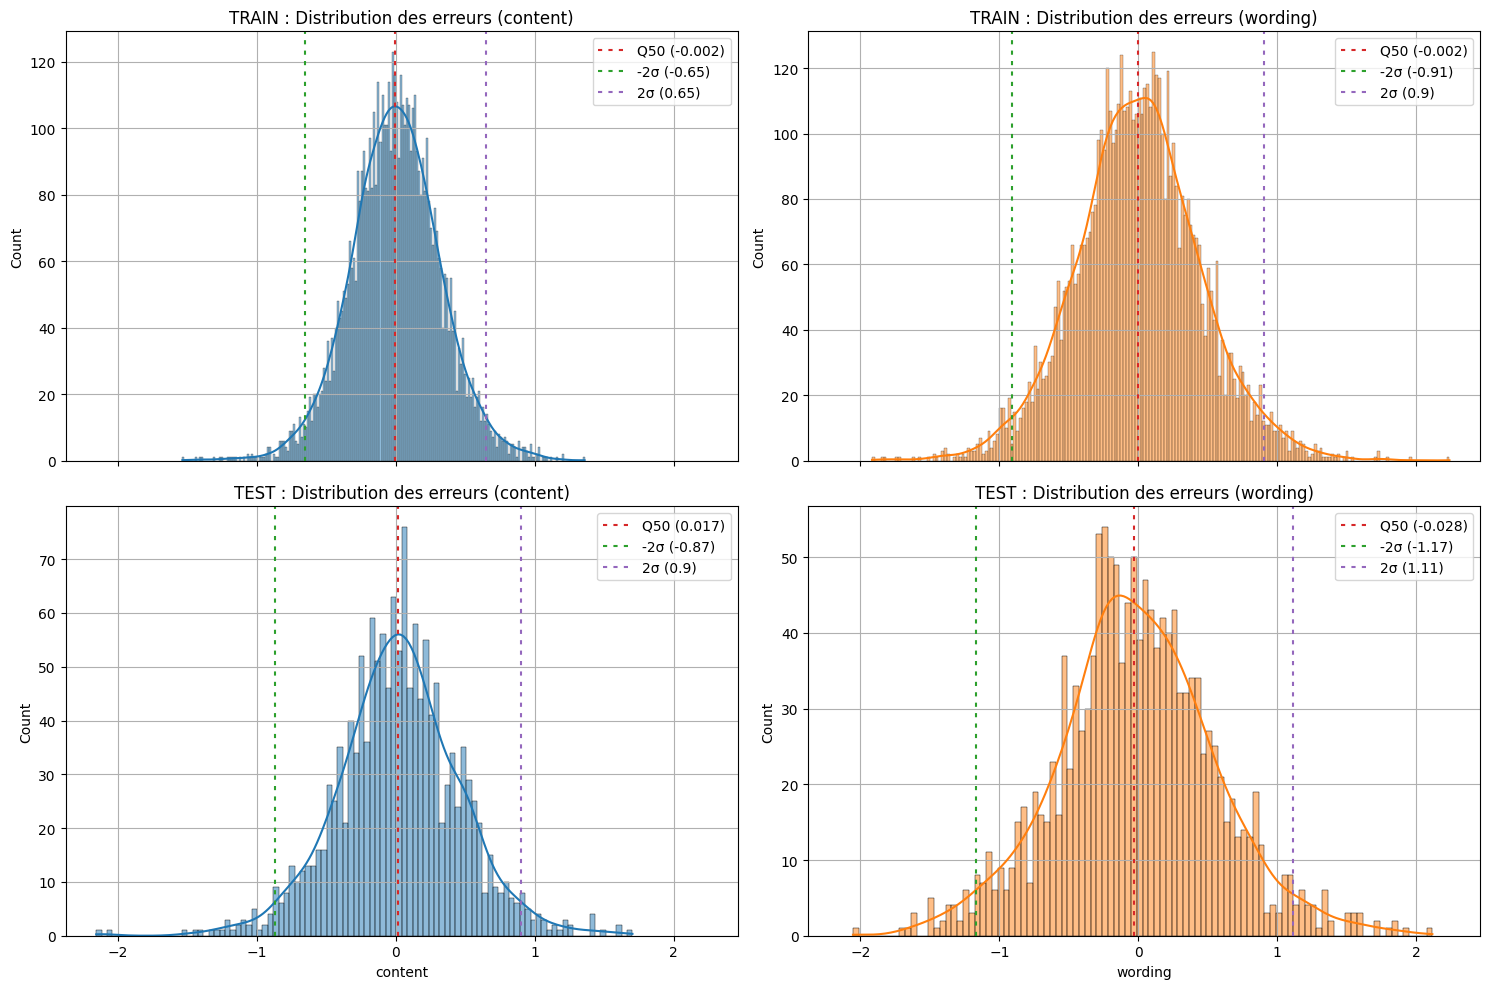

In [64]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True)

targets = [[train_error_content, train_error_wording], [test_error_content, test_error_wording]]

for i in range(2):
    for j in range(2):
        target = targets[i][j]
        sns.histplot(target, fill=True, bins=200-i*100, kde=True, color=f'C{j}', ax=axs[i, j], legend=['content', 'wording'][j])
        axs[i, j].axvline(target.median(), color='C3', linestyle='--', dashes=(2,3), label=f'Q50 ({round(target.median(),3)})')
        axs[i, j].axvline(target.median()-target.std()*2, color='C2', linestyle='--', dashes=(2,3), label=f'-2σ ({round(target.median()-target.std()*2,2)})')
        axs[i, j].axvline(target.median()+target.std()*2, color='C4', linestyle='--', dashes=(2,3), label=f'2σ ({round(target.median()+target.std()*2,2)})')
        axs[i, j].set_xlabel(['content', 'wording'][j])
        axs[i, j].set_title(['TRAIN : ', 'TEST : '][i]+["Distribution des erreurs (content)", "Distribution des erreurs (wording)"][j])
        axs[i, j].grid()
        axs[i, j].legend()

plt.tight_layout()
plt.show()


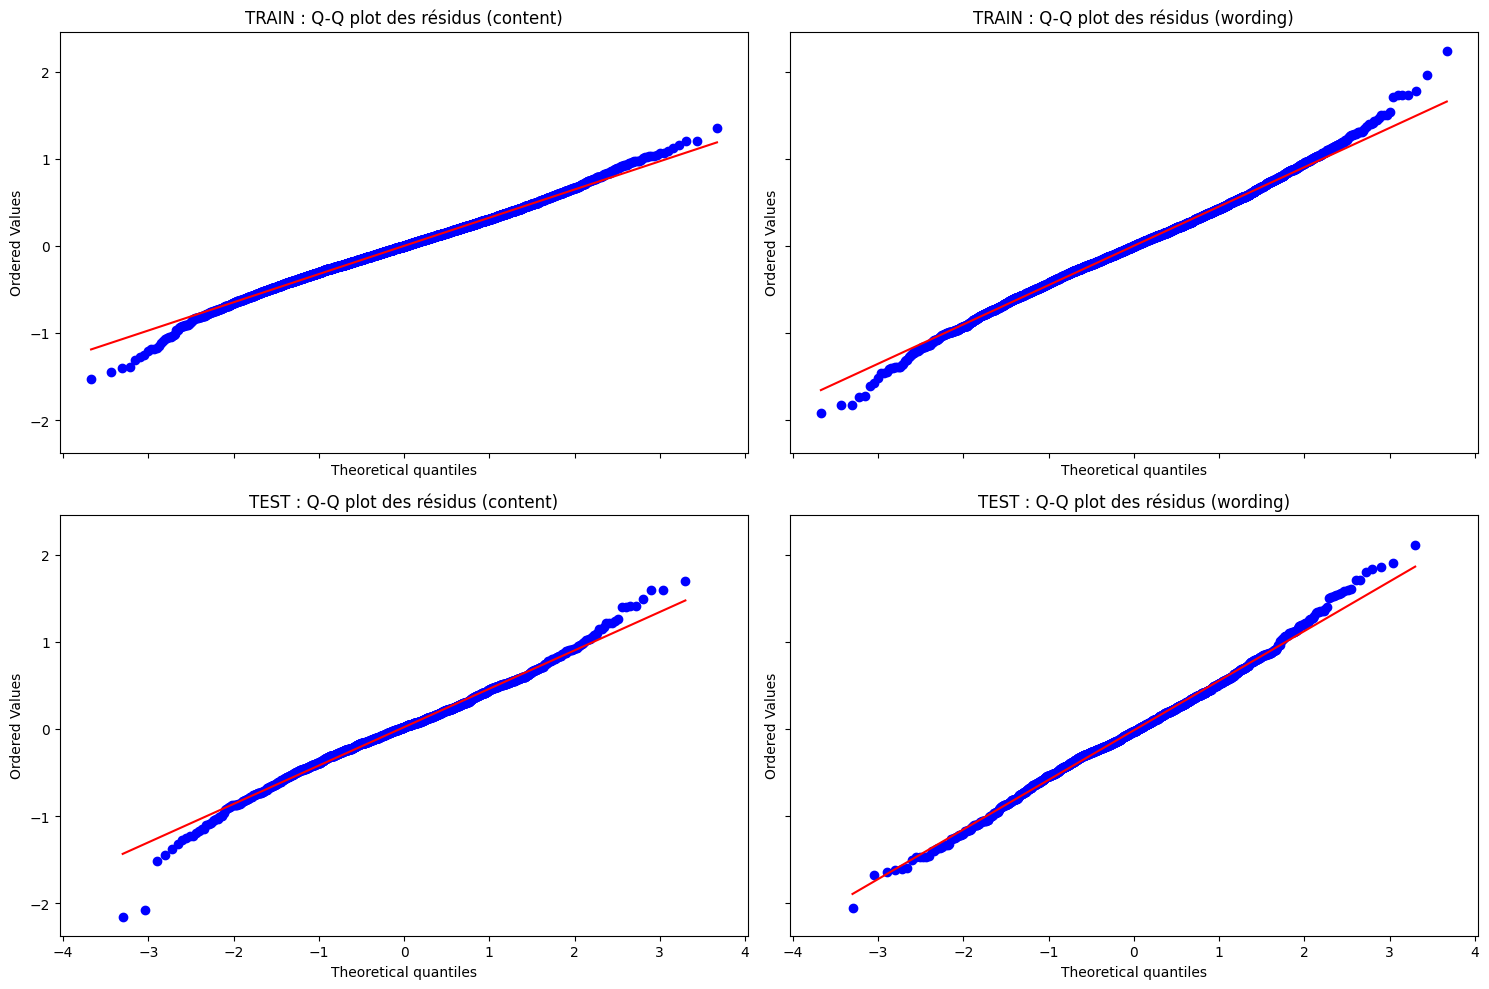

In [65]:
import scipy.stats as stats


fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

targets = [[[train_content_scaled_2['content'], predictions_train_content_3], [train_wording_scaled_2['wording'], predictions_train_wording_3]],
           [[test_content_scaled_2['content'], predictions_content_3], [test_wording_scaled_2['wording'], predictions_wording_3]]]

for i in range(2):
    for j in range(2):
        target = targets[i][j]
        residuals = target[0] - target[1]
        stats.probplot(residuals, dist="norm", plot=axs[i, j])
        axs[i, j].set_title(['TRAIN : ', 'TEST : '][i]+["Q-Q plot des résidus (content)", "Q-Q plot des résidus (wording)"][j])

plt.tight_layout()
plt.show()


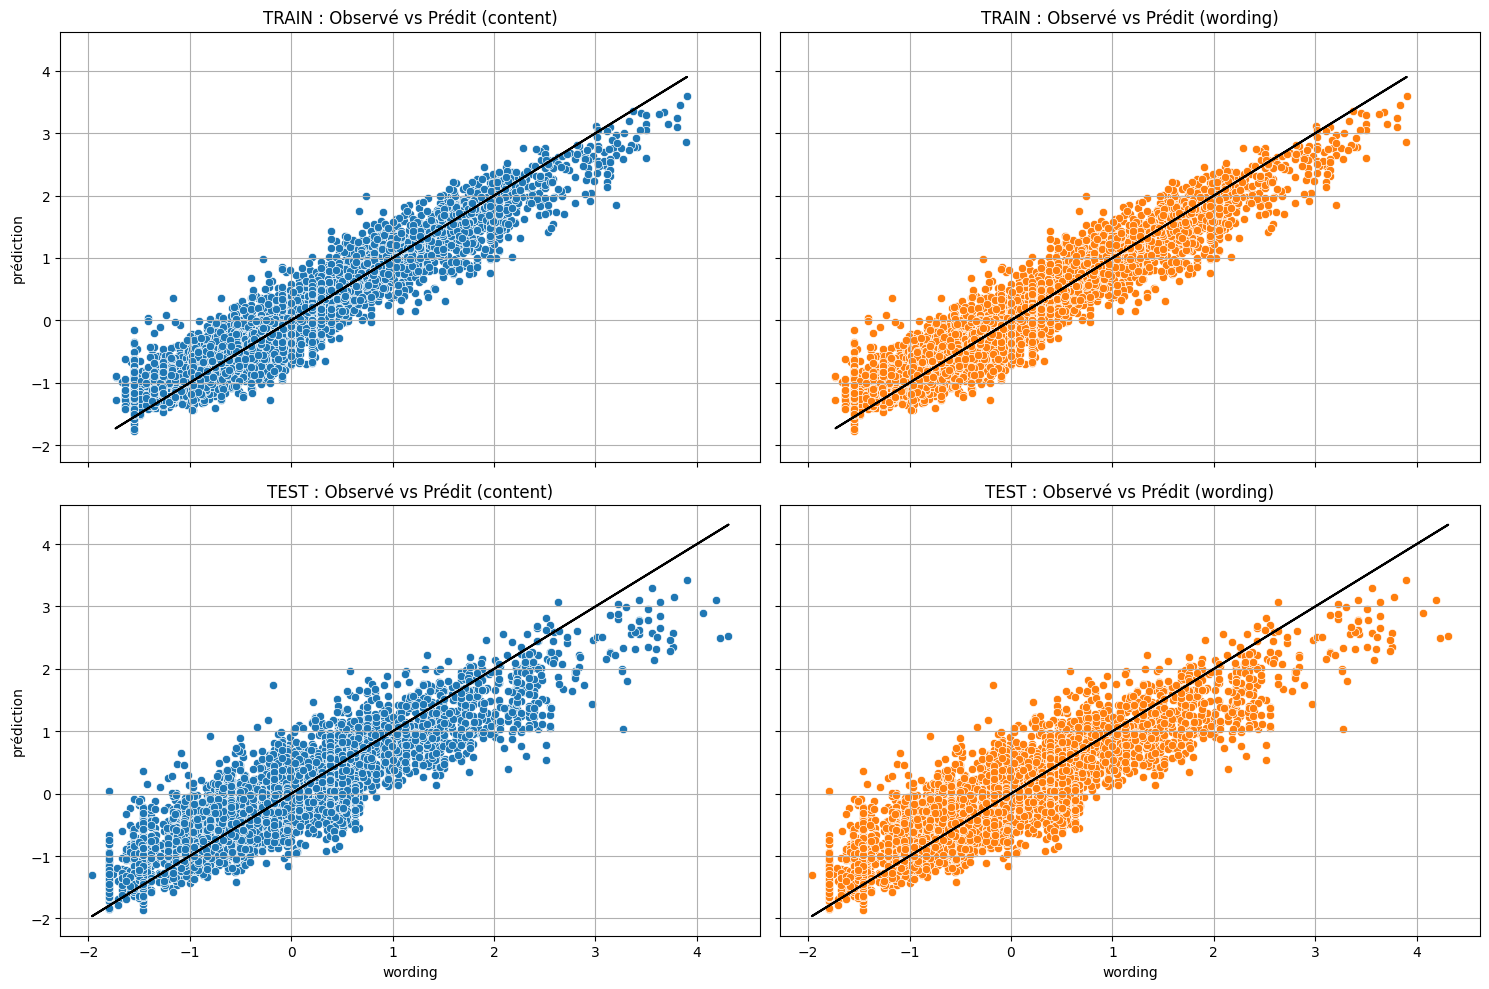

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

targets = [[train_content_scaled_2['content'], predictions_train_content_3], [train_wording_scaled_2['wording'], predictions_train_wording_3],
            [test_content_scaled_2['content'], predictions_content_3], [test_wording_scaled_2['wording'], predictions_wording_3]]

for i in range(2):
    for j in range(2):
        target = targets[i]
        sns.scatterplot(data=[train_content_scaled_2, train_wording_scaled_2, test_content_scaled_2, test_wording_scaled_2][i], x=target[0], y=target[1], color=f'C{j}', ax=axs[i, j])
        axs[i, j].plot(target[0], target[0], color=f'k')
        axs[i, j].set_xlabel(['content', 'wording'][i%2])
        axs[i, j].set_ylabel("prédiction")
        axs[i, j].set_title(['TRAIN : ', 'TEST : '][i]+["Observé vs Prédit (content)", "Observé vs Prédit (wording)"][j])
        axs[i, j].grid()

plt.tight_layout()
plt.show()


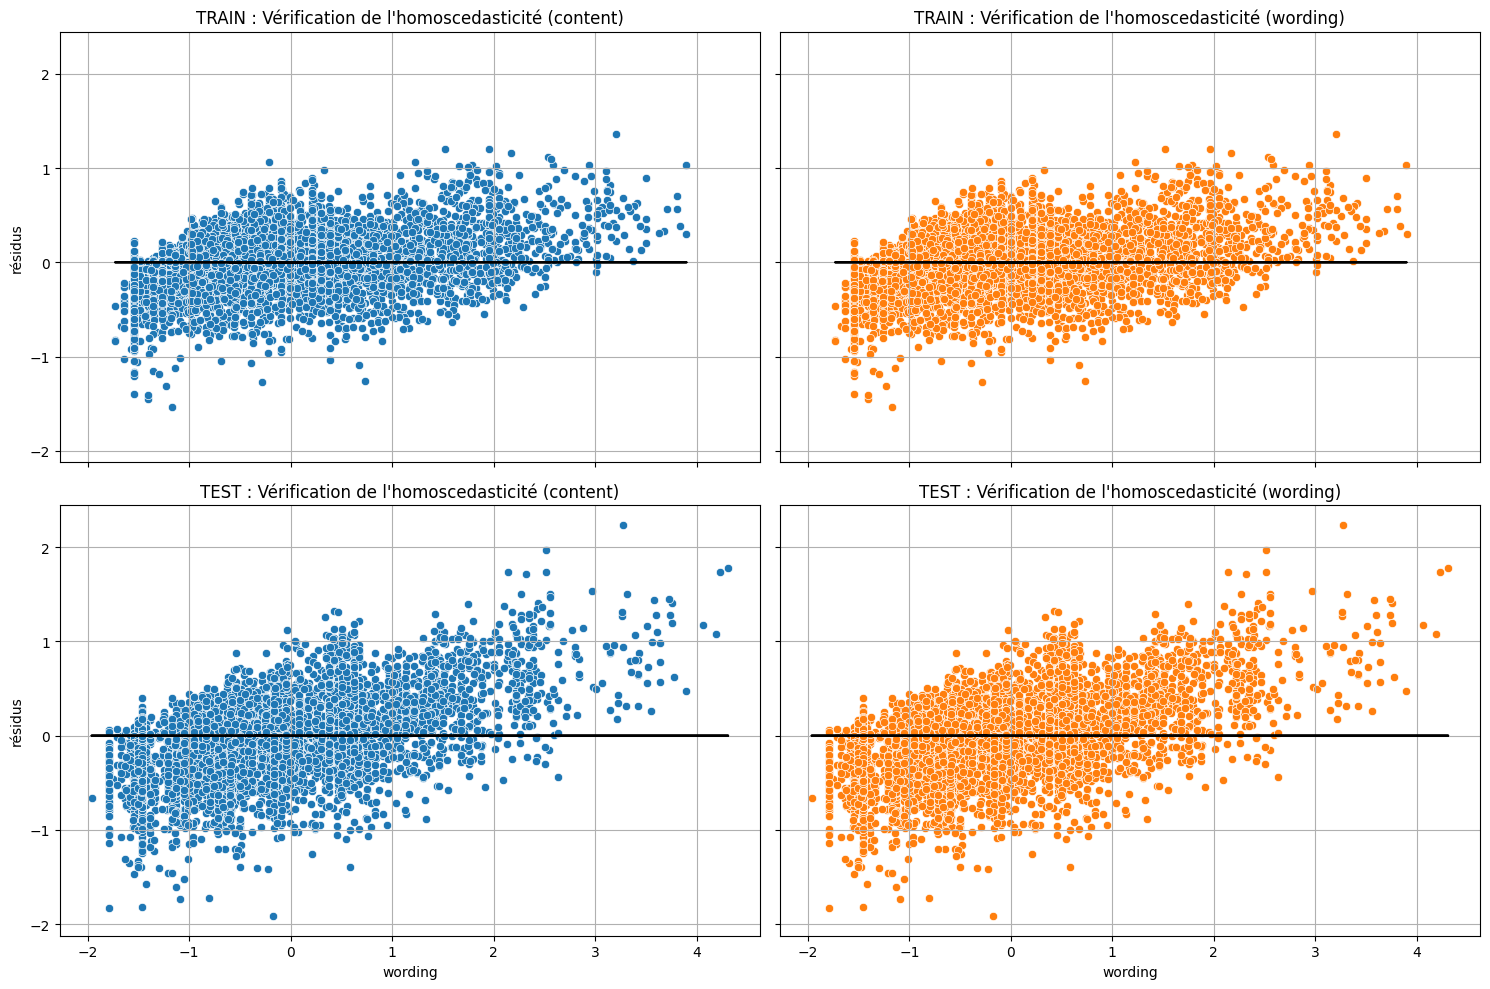

In [46]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

targets = [[train_content_scaled_2['content'], train_error_content], [train_wording_scaled_2['wording'], train_error_wording],
            [test_content_scaled_2['content'], test_error_content], [test_wording_scaled_2['wording'], test_error_wording]]

for i in range(2):
    for j in range(2):
        target = targets[i]
        sns.scatterplot(x=target[0], y=target[1], color=f'C{j}', ax=axs[i, j])
        axs[i, j].plot(target[0], target[0]-target[0], color='k')
        axs[i, j].set_xlabel(['content', 'wording'][i%2])
        axs[i, j].set_ylabel("résidus")
        axs[i, j].set_title(['TRAIN : ', 'TEST : '][i]+["Vérification de l'homoscedasticité (content)", "Vérification de l'homoscedasticité (wording)"][j])
        axs[i, j].grid()

plt.tight_layout()
plt.show()


# **Final models**

#### In order to improve on the scores of the original models we went through several steps that weren't originaly explored:
- #### **customizing features** for content and wording model
- #### extensive **feature engineering and selection**
- #### base **model change** (from Random Forest to **XGBoost**)
- #### iteratively **finetuning** the hyperparameters using **GridSearchCV**


#### <br> This table shows the scores obtained by both the original models and our final models:

| RMSE    | original (RF) | final model (XGB) | R²      | original (RF) | final model (XGB) |
|:-------:|:-------------:|:-----------------:|:-------:|:-------------:|:-----------------:|
| content | 0.5265        | **0.4438**        | content | 0.7513        | **0.8212**        |
| wording | 0.7850        | **0.5704**        | wording | 0.4123        | **0.6825**        |


#### <br> These steps allowed us to significantly increase the performance of both models, espcially the wording model:
- #### For the **content model**:
  - #### The **R²** saw a raw increase of **0.0699** which represent a **9.30%** improvement of the original score
  - #### The **rmse** saw a raw decrease of **0.0827** which represent a **15.71%** improvement of the original score
- #### For the **wording model**:
  - #### The **R²** saw a raw increase of **0.2702** which represent a **65.53%** improvement of the original score
  - #### The **rmse** saw a raw decrease of **0.2146** which represent a **27.34%** improvement of the original score